In [9]:
import nltk, re, string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sn

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Amruth
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Amruth
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Amruth
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [2]:
df=pd.read_csv('Final_Tobacco_Regulations_Data.csv')

In [6]:
df = df.drop('Unnamed: 0', 1)

In [7]:
df

,commentIds,comments
0,FDA-2012-D-0071-0272,If people are stupid enough to smoke then let ...
1,FDA-2012-D-0071-0391,We know what tobacco does already....this is s...
2,FDA-2013-N-0521-0306,"Comment from the Honorable Brian White, House ..."
3,FDA-2009-N-0294-0059,I believe this product needs to be banned alto...
4,FDA-2012-D-0071-0243,Please do not allow language that encourages o...
...,...,...
1966,FDA-2012-D-0071-1266,See attached file(s)
1967,FDA-2015-N-1514-0389,I am a pediatrician and strongly believe that ...
1968,FDA-2012-D-0071-0112,These deadly tests are included in the guidanc...
1969,FDA-2012-D-0071-0461,Please do not require animal testing to show w...


In [10]:
# We get started by importing spacy
import spacy
nlp = spacy.load("en_core_web_sm")

In [11]:
df['comments']=df['comments'].apply(str)

## Aspect and Description Extraction from comments

In [12]:
aspects = []
sentences=list(df["comments"])
for sentence in sentences:
    doc = nlp(sentence)
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            prepend = ''
            for child in token.children:
                if child.pos_ != 'ADV':
                    continue
                prepend += child.text + ' '
            descriptive_term = prepend + token.text
    aspects.append({'aspect': target,
                    'description': descriptive_term})
print(aspects)

[{'aspect': 'people', 'description': 'so cruel'}, {'aspect': 'tobacco', 'description': 'disabled'}, {'aspect': '', 'description': 'Honorable'}, {'aspect': 'Part', 'description': 'much'}, {'aspect': 'humans', 'description': 'humane'}, {'aspect': '', 'description': ''}, {'aspect': '', 'description': 'poor'}, {'aspect': 'companies', 'description': 'necessary'}, {'aspect': '', 'description': 'uneccessary'}, {'aspect': 'testing', 'description': 'horrifying'}, {'aspect': '', 'description': 'attached'}, {'aspect': '', 'description': ''}, {'aspect': 'Tobacco', 'description': 'worth'}, {'aspect': 'animals', 'description': 'compassionate'}, {'aspect': '', 'description': 'attached'}, {'aspect': '', 'description': 'negative'}, {'aspect': 'prices', 'description': 'blunt'}, {'aspect': '', 'description': ''}, {'aspect': 'government', 'description': 'true'}, {'aspect': '', 'description': ''}, {'aspect': 'smoke', 'description': 'bad'}, {'aspect': 'animal', 'description': 'available'}, {'aspect': '', 'd

Sentiment Tagging was made using 3 different sentiment identifiers :
1. Text Blob Applied on aspect's description 
2. Vader Sentiment applied on cleaned comment
3. Flair Sentiment applied on complete comment 

Based on higest occurance of 3 sentiment identifiers used finally the sentiment was selected

In [13]:
# text blob Sentiment extraction using polarity score
from textblob import TextBlob
for aspect in aspects:
    aspect['Text_Blob_Polaritysentiment'] = TextBlob(aspect['description']).sentiment[0]
print(aspects)

[{'aspect': 'people', 'description': 'so cruel', 'Text_Blob_Polaritysentiment': -1.0}, {'aspect': 'tobacco', 'description': 'disabled', 'Text_Blob_Polaritysentiment': -0.2}, {'aspect': '', 'description': 'Honorable', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': 'Part', 'description': 'much', 'Text_Blob_Polaritysentiment': 0.2}, {'aspect': 'humans', 'description': 'humane', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': '', 'description': '', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': '', 'description': 'poor', 'Text_Blob_Polaritysentiment': -0.4}, {'aspect': 'companies', 'description': 'necessary', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': '', 'description': 'uneccessary', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': 'testing', 'description': 'horrifying', 'Text_Blob_Polaritysentiment': -0.9}, {'aspect': '', 'description': 'attached', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': '', 'description': '', 'Text_Blob_Polaritysentiment': 0.0}, {'aspect': 'Tobacco', 'desc

In [14]:
def find_index(comment, aspect):
    aspect_list = aspect.split(",")
    for aspect_ in aspect_list:
        if aspect_.lower() in comment.lower():
            index_ = comment.lower().find(aspect_)
            if index_ == -1: return str(len(comment)-len(aspect_))+"-"+str(len(comment))
            else: return str(index_)+"-"+str(index_+len(aspect_))

In [16]:
#Defining functions for pre-processing
stopwords_list = stopwords.words('english') # importing stopwords
punctuations_list = string.punctuation # get punctuations
lemmatizer = WordNetLemmatizer() # initialize word lemmatizer

def filter_annotation(annotator):
    (Text_blob_Sentiment, Vader_Sentiment, Flair_Sentiment) = annotator
    if Text_blob_Sentiment=='POSITIVE' and Vader_Sentiment=='POSITIVE' and Flair_Sentiment=='POSITIVE': return "Positive"
    elif Text_blob_Sentiment=='NEGATIVE' and Vader_Sentiment=='NEGATIVE' and Flair_Sentiment=='NEGATIVE': return "Negative"
    elif Text_blob_Sentiment=='NEUTRAL' and Vader_Sentiment=='NEUTRAL' and Flair_Sentiment=='NEUTRAL': return "Neutral"
    elif (Text_blob_Sentiment=='POSITIVE' and Vader_Sentiment=='POSITIVE') or  (Vader_Sentiment=='POSITIVE' and Flair_Sentiment=='POSITIVE') or (Flair_Sentiment=='POSITIVE' and Text_blob_Sentiment=='POSITIVE'): return "Positive"
    elif (Text_blob_Sentiment=='NEGATIVE' and Vader_Sentiment=='NEGATIVE') or (Vader_Sentiment=='NEGATIVE' and Flair_Sentiment=='NEGATIVE') or (Flair_Sentiment=='NEGATIVE' and Text_blob_Sentiment=='NEGATIVE'): return "Negative"
    elif (Text_blob_Sentiment=='NEUTRAL' and Vader_Sentiment=='NEUTRAL') or (Vader_Sentiment=='NEUTRAL' and Flair_Sentiment=='NEUTRAL') or (Flair_Sentiment=='NEUTRAL' and Text_blob_Sentiment=='NEUTRAL'): return "Neutral"
    else: return 'Neutral'

def preprocessing(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = text + " ".join(emoticons).replace('-', '')
    tokenize_text = [lemmatizer.lemmatize(word) for word in nltk.tokenize.word_tokenize(text) 
                     if (word not in stopwords_list) and (word not in punctuations_list) and (len(word)>=2) and (word.isalpha())]
    return " ".join(tokenize_text)

In [17]:
df_aspects=pd.DataFrame(aspects)

In [18]:
comments_df=pd.concat([df,df_aspects],axis=1)

In [19]:
# Vader Sentiment extraction using compound score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_score=[]
analyzer = SentimentIntensityAnalyzer()
for i in comments_df['comments']:
    vs = analyzer.polarity_scores(i)
    vader_score.append(vs['compound'])

In [20]:
#Applying above defined functions to the dataframe
comments_df["Clean_Comment"] = comments_df["comments"].apply(preprocessing)
comments_df["Aspect Index"] = comments_df[['comments','aspect']].apply(lambda x: find_index(*x), axis=1)
comments_df['vader_score']=vader_score
comments_df.head(5)

,commentIds,comments,aspect,description,Text_Blob_Polaritysentiment,Clean_Comment,Aspect Index,vader_score
0,FDA-2012-D-0071-0272,If people are stupid enough to smoke then let ...,people,so cruel,-1.0,people stupid enough smoke let force helpless ...,3-9,-0.8261
1,FDA-2012-D-0071-0391,We know what tobacco does already....this is s...,tobacco,disabled,-0.2,know tobacco already sheer stupidity ignorance...,13-20,-0.4019
2,FDA-2013-N-0521-0306,"Comment from the Honorable Brian White, House ...",,Honorable,0.0,comment honorable brian white house representa...,0-0,0.5423
3,FDA-2009-N-0294-0059,I believe this product needs to be banned alto...,Part,much,0.2,believe product need banned altogether inlaws ...,442-446,-0.9041
4,FDA-2012-D-0071-0243,Please do not allow language that encourages o...,humans,humane,0.0,please allow language encourages allows new an...,174-180,0.6842


In [21]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [22]:
comments_df['Text_blob_Sentiment']=comments_df['Text_Blob_Polaritysentiment'].apply(getAnalysis)
comments_df['Vader_Sentiment']=comments_df['vader_score'].apply(getAnalysis)

In [23]:
# Flair Sentiment Extraction
from flair.models import TextClassifier
from flair.data import Sentence
Flair_sentiment=[]
classifier = TextClassifier.load('en-sentiment')
for i in comments_df['comments']:
    sentence = Sentence(i)
    classifier.predict(sentence)
    #print(str(sentence.labels).split("'/'")[1].split("'")[0])
    # print sentence with predicted labels
    Flair_sentiment.append(str(sentence.labels).split("'/'")[1].split("'")[0])

2022-04-27 23:20:17,708 loading file C:\Users\Amruth PC\.flair\models\sentiment-en-mix-distillbert_4.pt


In [24]:
comments_df['Flair_Sentiment']=Flair_sentiment

In [25]:
comments_df['Text_blob_Sentiment']=comments_df['Text_blob_Sentiment'].str.upper()
comments_df['Vader_Sentiment']=comments_df['Vader_Sentiment'].str.upper()

In [26]:
#Using 3 sentiments identifying the max outcome as main sentiment
annotator = list(zip(comments_df["Text_blob_Sentiment"], comments_df["Vader_Sentiment"], comments_df["Flair_Sentiment"]))
comments_df["Annotator"] = list(map(filter_annotation, annotator))

In [27]:
comments_df['Annotator'].value_counts()

Negative    995
Neutral     634
Positive    342
Name: Annotator, dtype: int64

In [28]:
def absolute_sentiment(sentiment):
    if sentiment=="Positive": return 1
    elif sentiment=="Negative": return -1
    else: return 0

comments_df['Triple_Sentiment'] = comments_df['Annotator'].apply(absolute_sentiment)
comments_df['Text_blob_Sentiment_Numerical'] = comments_df['Text_blob_Sentiment'].apply(absolute_sentiment)
comments_df['Vader_Sentiment_Numerical'] = comments_df['Vader_Sentiment'].apply(absolute_sentiment)
comments_df['Flair_Sentiment_Numerical'] = comments_df['Flair_Sentiment'].apply(absolute_sentiment)
comments_df.head(5)

,commentIds,comments,aspect,description,Text_Blob_Polaritysentiment,Clean_Comment,Aspect Index,vader_score,Text_blob_Sentiment,Vader_Sentiment,Flair_Sentiment,Annotator,Triple_Sentiment,Text_blob_Sentiment_Numerical,Vader_Sentiment_Numerical,Flair_Sentiment_Numerical
0,FDA-2012-D-0071-0272,If people are stupid enough to smoke then let ...,people,so cruel,-1.0,people stupid enough smoke let force helpless ...,3-9,-0.8261,NEGATIVE,NEGATIVE,NEGATIVE,Negative,-1,0,0,0
1,FDA-2012-D-0071-0391,We know what tobacco does already....this is s...,tobacco,disabled,-0.2,know tobacco already sheer stupidity ignorance...,13-20,-0.4019,NEGATIVE,NEGATIVE,NEGATIVE,Negative,-1,0,0,0
2,FDA-2013-N-0521-0306,"Comment from the Honorable Brian White, House ...",,Honorable,0.0,comment honorable brian white house representa...,0-0,0.5423,NEUTRAL,POSITIVE,POSITIVE,Positive,1,0,0,0
3,FDA-2009-N-0294-0059,I believe this product needs to be banned alto...,Part,much,0.2,believe product need banned altogether inlaws ...,442-446,-0.9041,POSITIVE,NEGATIVE,NEGATIVE,Negative,-1,0,0,0
4,FDA-2012-D-0071-0243,Please do not allow language that encourages o...,humans,humane,0.0,please allow language encourages allows new an...,174-180,0.6842,NEUTRAL,POSITIVE,NEGATIVE,Neutral,0,0,0,0


## Exploratory Data Analysis

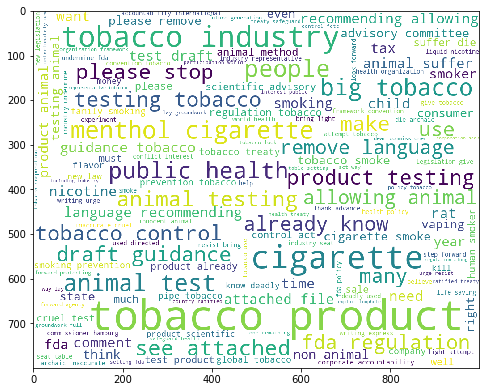

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
comments_combined = " ".join(comments_df.Clean_Comment.values)
word_cloud = WordCloud(width=1000,height=800,background_color='white',
                       max_words=150).\
generate_from_text(comments_combined)
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.show()

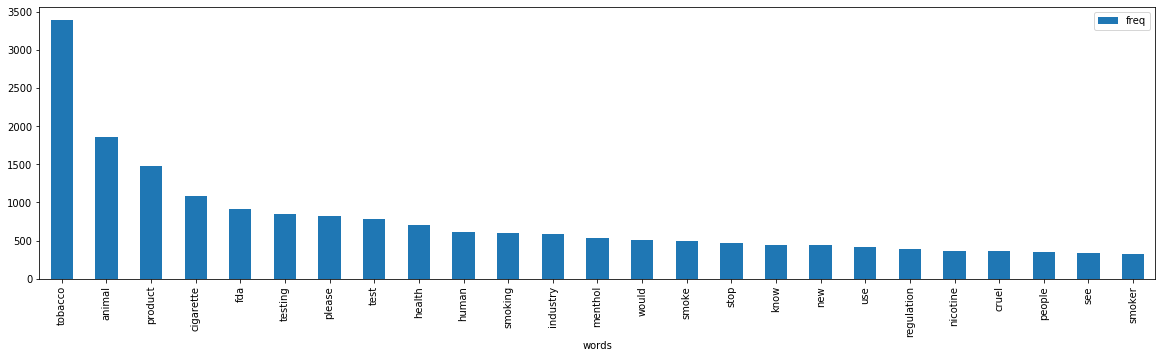

In [33]:
all_terms = []
fdist = {}
all_terms = comments_combined.split(" ")
for word in all_terms:
    fdist[word] = fdist.get(word,0) + 1
freq = {"words":list(fdist.keys()),"freq":list(fdist.values())}
df_dist = pd.DataFrame(freq)
df_dist.sort_values(ascending=False,by="freq").head(25)
%matplotlib inline
df_dist.sort_values(ascending=False, by="freq").head(25).\
plot.bar(x= "words", y= "freq",figsize=(20,5)) 

In [36]:
comments_df.columns

Index(['commentIds', 'comments', 'aspect', 'description',
       'Text_Blob_Polaritysentiment', 'Clean_Comment', 'Aspect Index',
       'vader_score', 'Text_blob_Sentiment', 'Vader_Sentiment',
       'Flair_Sentiment', 'Annotator', 'Triple_Sentiment',
       'Text_blob_Sentiment_Numerical', 'Vader_Sentiment_Numerical',
       'Flair_Sentiment_Numerical'],
      dtype='object')

## Building a Model

In [38]:
comment = comments_df["Clean_Comment"]
sentiment = comments_df["Triple_Sentiment"]

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

In [40]:
X_train

804     dear commissioner hamburg writing express beli...
1634    modified risk tobacco product application docu...
589     completely wrong subject animal testing tobacc...
265     even think test barbaric well known fact tobac...
669     maybe something tobacco company raising ph lev...
                              ...                        
52      keep short simple stuffing poor innocent rat t...
758                       please see attached set comment
626                                  see attached comment
402     dear sir madam write urge fda remove language ...
1063                                                  nan
Name: Clean_Comment, Length: 1379, dtype: object

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_bow = tfidf_vect.fit_transform(X_train)
X_test_bow = tfidf_vect.transform(X_test)

In [45]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
mng=MultinomialNB()
mng.fit(X_train_bow,Y_train)
from sklearn.metrics import confusion_matrix
print("Multinomial Score=",mng.score(X_test_bow,Y_test)*100)
Y_pred = mng.predict(X_test_bow)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix is :",cm,sep='\n')

Multinomial Score= 72.80405405405406
Confusion Matrix is :
[[296   0   3]
 [ 83 104   3]
 [ 65   7  31]]


Accuracy:  0.7280405405405406
Navie Bayes accuracy on train data:  75.0 %
Navie Bayes accuracy on test data:  73.0 %
              precision    recall  f1-score   support

          -1       0.99      0.67      0.80       444
           0       0.55      0.94      0.69       111
           1       0.30      0.84      0.44        37

    accuracy                           0.73       592
   macro avg       0.61      0.81      0.64       592
weighted avg       0.86      0.73      0.75       592



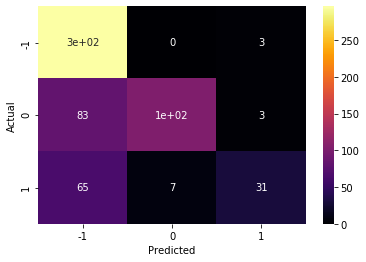

In [51]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
print("Navie Bayes accuracy on train data: ", round(mng.score(X_train_bow,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(mng.score(X_test_bow,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))


SGD Score= 74.83108108108108
Confusion Matrix is :
[[258  23  18]
 [ 43 138   9]
 [ 31  25  47]]
SGD accuracy on train data:  99.0 %
SGD accuracy on test data:  75.0 %
              precision    recall  f1-score   support

          -1       0.86      0.78      0.82       332
           0       0.73      0.74      0.73       186
           1       0.46      0.64      0.53        74

    accuracy                           0.75       592
   macro avg       0.68      0.72      0.69       592
weighted avg       0.77      0.75      0.76       592



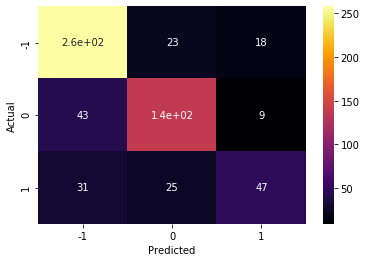

In [58]:
from sklearn.model_selection import cross_val_score
SGD_Classifier= SGDClassifier()
SGD_Classifier.fit(X_train_bow,Y_train)

from sklearn.metrics import confusion_matrix
print("SGD Score=",SGD_Classifier.score(X_test_bow,Y_test)*100)
Y_pred = SGD_Classifier.predict(X_test_bow)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix is :",cm,sep='\n')

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SGD accuracy on train data: ", round(SGD_Classifier.score(X_train_bow,Y_train)*100), '%')
print("SGD accuracy on test data: ", round(SGD_Classifier.score(X_test_bow,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))


Decision Tree Score= 71.11486486486487
Confusion Matrix is :
[[237  33  29]
 [ 41 136  13]
 [ 32  23  48]]
Decision Tree accuracy on train data:  100.0 %
Decision Tree accuracy on test data:  71.0 %
              precision    recall  f1-score   support

          -1       0.79      0.76      0.78       310
           0       0.72      0.71      0.71       192
           1       0.47      0.53      0.50        90

    accuracy                           0.71       592
   macro avg       0.66      0.67      0.66       592
weighted avg       0.72      0.71      0.71       592



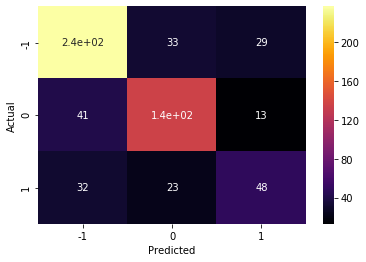

In [63]:
from sklearn.model_selection import cross_val_score
DT_Classifier= DecisionTreeClassifier()
DT_Classifier.fit(X_train_bow,Y_train)

from sklearn.metrics import confusion_matrix
print("Decision Tree Score=",DT_Classifier.score(X_test_bow,Y_test)*100)
Y_pred = DT_Classifier.predict(X_test_bow)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix is :",cm,sep='\n')

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_Classifier.score(X_train_bow,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_Classifier.score(X_test_bow,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))


Random Forest Score= 75.33783783783784
Confusion Matrix is :
[[284  14   1]
 [ 58 129   3]
 [ 58  12  33]]
Random Forest accuracy on train data:  100.0 %
Random Forest accuracy on test data:  71.0 %
              precision    recall  f1-score   support

          -1       0.95      0.71      0.81       400
           0       0.68      0.83      0.75       155
           1       0.32      0.89      0.47        37

    accuracy                           0.75       592
   macro avg       0.65      0.81      0.68       592
weighted avg       0.84      0.75      0.77       592



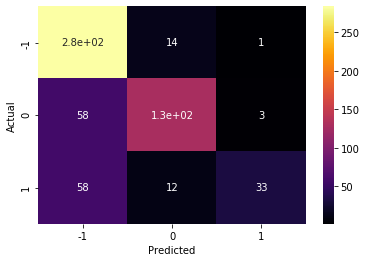

In [62]:
from sklearn.model_selection import cross_val_score
RF_Classifier= RandomForestClassifier()
RF_Classifier.fit(X_train_bow,Y_train)

from sklearn.metrics import confusion_matrix
print("Random Forest Score=",RF_Classifier.score(X_test_bow,Y_test)*100)
Y_pred = RF_Classifier.predict(X_test_bow)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix is :",cm,sep='\n')

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(DT_Classifier.score(X_train_bow,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(DT_Classifier.score(X_test_bow,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))


Logistic Regression Score= 76.6891891891892
Confusion Matrix is :
[[285   6   8]
 [ 55 130   5]
 [ 49  15  39]]
Logistic Regression accuracy on train data:  88.0 %
Logistic Regression accuracy on test data:  77.0 %
              precision    recall  f1-score   support

          -1       0.95      0.73      0.83       389
           0       0.68      0.86      0.76       151
           1       0.38      0.75      0.50        52

    accuracy                           0.77       592
   macro avg       0.67      0.78      0.70       592
weighted avg       0.83      0.77      0.78       592



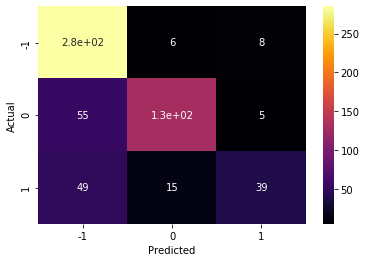

In [61]:
from sklearn.model_selection import cross_val_score
LR_Classifier= LogisticRegression(max_iter=1000)
LR_Classifier.fit(X_train_bow,Y_train)

from sklearn.metrics import confusion_matrix
print("Logistic Regression Score=",LR_Classifier.score(X_test_bow,Y_test)*100)
Y_pred = LR_Classifier.predict(X_test_bow)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix is :",cm,sep='\n')

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logistic Regression accuracy on train data: ", round(LR_Classifier.score(X_train_bow,Y_train)*100), '%')
print("Logistic Regression accuracy on test data: ", round(LR_Classifier.score(X_test_bow,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))